# Model evaluation 4D

This notebook is used to visualize the compression errors of a specific AE trained on a 4-dimensional jet dataset.

In [3]:
import os
import uproot
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import corner

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from fastai.metrics import mse
from fastai.callback import schedule

import vector

import glob

In [4]:
plt.rcParams.update({'font.size': 16, 'lines.markersize' : 10, 'image.cmap' : 'tab20b'})

# Viewing the results of a single model

In [5]:
# OLD
# View info
# These are the 500 epoch d2lep long run norm scheme comparison models
#20211026113204.run #d2lep
#20211026114307.run #data18 
#20211026114315.run
path = r'F:\Master\Data\storage\model-info'
filenames = []
run_nrs = [20211026113204, 20211026114307, 20211026114315, 20211026113128, 20211025142826, 20211025142759, 20211025125622, 20211025125551, 20211026113128, 20211025125551]

for run_nr in run_nrs:
    filename = glob.glob(os.sep.join([path, '*'+str(run_nr)+'*']))
    filenames += filename

In [11]:
# Use for new, run-specific directory setup
storage_path = r'F:\Master\Data\storage'

#run_nrs = [20211028201105, 20211028150801, 20211028150722, 20211028150713]
run_nrs = [20211026113204, 20211101114815, 20211101124718, 20211104113505, 20211028201105, 20211028150801, 20211028150722, 20211028150713] # single + all intermediate
#run_nrs = [20211101175646, 20211101175647, 20211101175649, 20211101175648, 20211102035713, 20211101175700, 20211108161124, 20211101181052, 20211101175702, 20211101175701, 20211101175704, 20211101175706, 20211101175705, 20211101175703, 20211101175709] # all non-intermediate models

orig_pred_path = {}
info_path = {}
for run_nr in run_nrs:
    folder = glob.glob(os.sep.join([storage_path, 'run_'+str(run_nr)+'*']))[0]
    orig_pred_path[run_nr] = os.sep.join([folder, 'orig-pred'])
    info_path[run_nr] = os.sep.join([folder, 'model-info'])

full_names = {}
model_names_dict = {}
for run_nr in run_nrs:
    this_path = os.sep.join([info_path[run_nr], 'run_'+str(run_nr)+'*'])
    full_names[run_nr] = []
    full_names[run_nr] += glob.glob(this_path)
    model_names_dict[run_nr] = []
    for model_name in full_names[run_nr]:
        model_names_dict[run_nr].append(model_name[model_name.rfind('run'):model_name.rfind('.info')])

In [12]:
# Use for new, run-specific directory setup
origs = {}
preds = {}
info = {}
architecture = {}
model_names = []

t = time.perf_counter()
for run_nr in run_nrs:
    for i, model_name in enumerate(model_names_dict[run_nr]):
        try:
            full_info = pd.read_pickle(os.sep.join([info_path[run_nr], model_name+'.info']))
            filename = os.sep.join([orig_pred_path[run_nr], model_name+'_orig-pred.pkl'])
            origs[model_name], preds[model_name] = pd.read_pickle(filename)
            if i == 0:
                branches = origs[model_name].columns

            info[model_name] = full_info[0]
            try:
                architecture[model_name] = full_info[2]
            except:
                print('Architecture not available for model', model_name)
            model_names.append(model_name)
        except FileNotFoundError:
            print('File not found:', filename)
        
print('Total run time:', time.perf_counter() - t, 'seconds.')
try:
    print('Intermediate setting of last model is:', info[model_name]['intermediate'])
except:
    print('No intermediate setting of last model available.')
print('Architecture of an example model:', list(architecture.items())[0])
print('Number of models:', len(model_names))

Total run time: 5.3541119000001345 seconds.
Intermediate setting of last model is: True
Architecture of an example model: ('run_20211026113204_d2lep_dim_4_same_event_1_3', '4-200-100-50-3-50-100-200-4, activation function: Tanh()')
Number of models: 19


In [6]:
# Old
path = r'F:\Master\Data\storage\orig-pred'
suffix = '_orig-pred.pkl'
data_files = []
interesting_runs = []
for run_nr in run_nrs:
    data_file = glob.glob(os.sep.join([path, '*'+str(run_nr)+'*']))
    data_files += data_file
for filename, data_file in zip(filenames, data_files):
    info = pd.read_pickle(filename)
    #data_file = info[1] + suffix
    #try:
    orig, _ = pd.read_pickle(data_file)
    print(info)
    print(orig.columns)
    #except:
    print(data_file, 'not available.')  
    print()
    if 'm' in orig.columns or 'Calculated_E' in orig.columns:
        interesting_runs.append(data_file)

({'n_features': 4, 'group_size': 1, 'latent_space_size': 3, 'mode': 'same_event', 'intermediate': False, 'name': 'same_event_1_3', 'n_epochs': 500, 'model_type': 'single'}, 'run_20211026113204_d2lep_dim_4_same_event_1_3', '4-200-100-50-3-50-100-200-4, activation function: Tanh()')
Index(['pt', 'eta', 'phi', 'E'], dtype='object')
F:\Master\Data\storage\orig-pred\run_20211026113204_d2lep_dim_4_same_event_1_3_orig-pred.pkl not available.

({'n_features': 4, 'group_size': 1, 'latent_space_size': 3, 'mode': 'same_event', 'intermediate': False, 'name': 'same_event_1_3', 'n_epochs': 500, 'model_type': 'single', 'scheme': 'log'}, 'run_20211026114307_d2lep_dim_4_same_event_1_3', '4-200-100-50-3-50-100-200-4, activation function: Tanh()')
Index(['pt', 'eta', 'phi', 'E'], dtype='object')
F:\Master\Data\storage\orig-pred\run_20211026114307_d2lep_dim_4_same_event_1_3_orig-pred.pkl not available.

({'n_features': 4, 'group_size': 1, 'latent_space_size': 3, 'mode': 'same_event', 'intermediate': False

In [7]:
# run_20211025125622_data18_dim_4_calcE_same_event_1_3_orig-pred.pkl # for calculated energy
# run_20211025125551_data18_dim_4_m_same_event_1_3_orig-pred.pkl # for mass
interesting_runs

['F:\\Master\\Data\\storage\\orig-pred\\run_20211026113128_data18_dim_4_same_event_1_3_orig-pred.pkl',
 'F:\\Master\\Data\\storage\\orig-pred\\run_20211025125622_data18_dim_4_calcE_same_event_1_3_orig-pred.pkl',
 'F:\\Master\\Data\\storage\\orig-pred\\run_20211025125551_data18_dim_4_m_same_event_1_3_orig-pred.pkl',
 'F:\\Master\\Data\\storage\\orig-pred\\run_20211026113128_data18_dim_4_same_event_1_3_orig-pred.pkl',
 'F:\\Master\\Data\\storage\\orig-pred\\run_20211025125551_data18_dim_4_m_same_event_1_3_orig-pred.pkl']

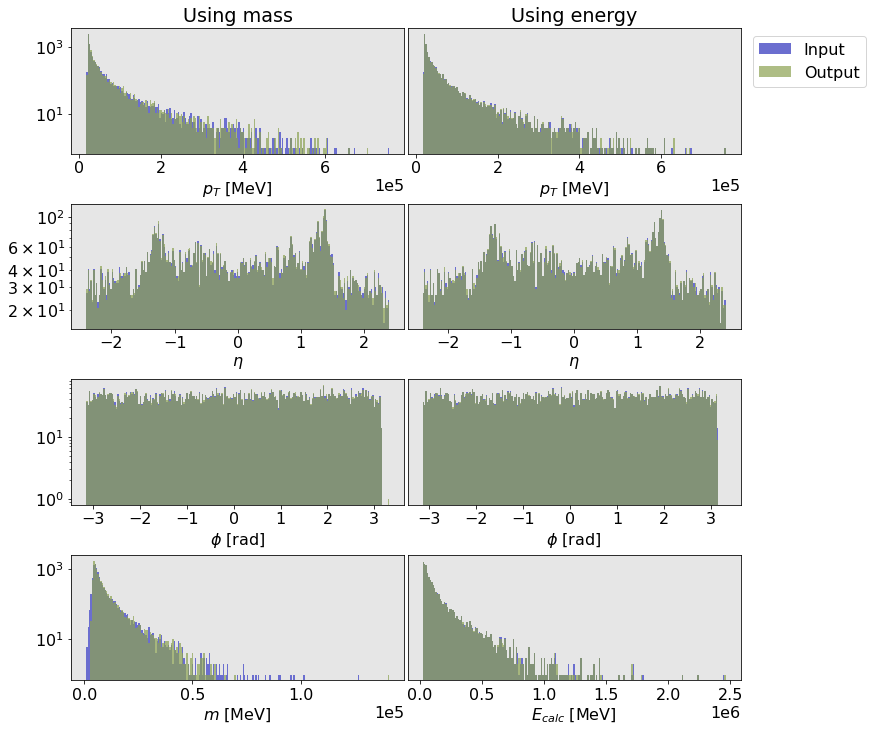

In [8]:
# Comparing use of mass and calculated energy

path = r'F:\Master\Data\storage\orig-pred'
filenames = ['run_20211025125551_data18_dim_4_m_same_event_1_3_orig-pred.pkl', 'run_20211025125622_data18_dim_4_calcE_same_event_1_3_orig-pred.pkl']

fig = plt.figure(figsize=(12, 12))
cmap = plt.get_cmap('tab20b')
colors = [cmap.colors[2], cmap.colors[5]]
ylims = []
n_bins = 216

origs = {}
preds = {}
limits = {}
resses = []
fourth_variable = ['mass', 'energy']
units = {'pt' : '[MeV]', 'eta' : '', 'phi' : '[rad]', 'Calculated_E' : '[MeV]', 'm' : '[MeV]'}

for f, filename in enumerate(filenames):
    orig, pred = pd.read_pickle(os.sep.join([path, filename]))
    origs[fourth_variable[f]] = orig
    preds[fourth_variable[f]] = pred
    
    branches = orig.columns
    for branch in branches:
        try:
            limits[branch] = (min(limits[branch][0], min(orig[branch]), min(pred[branch])), max(limits[branch][1], max(orig[branch]), max(pred[branch])))
        except:
            limits[branch] = (np.Inf, -np.Inf)
            limits[branch] = (min(limits[branch][0], min(orig[branch]), min(pred[branch])), max(limits[branch][1], max(orig[branch]), max(pred[branch])))

for f, filename in enumerate(filenames):    
    orig = origs[fourth_variable[f]]
    pred = preds[fourth_variable[f]]
    branches = orig.columns
    
    labels = ['$p_T$', '$\eta$', '$\phi$']
    if 'Calculated_E' in branches:
        fourth_label = '$E_{calc}$'
    elif 'm' in branches:
        fourth_label = '$m$'
    else:
        fourth_label = '$E$'
    labels.append(fourth_label)
    res_types = ['response', 'residual', 'residual', 'response']
    res_type = dict(zip(branches, res_types))
    
    res = pred - orig
    for branch in branches:
        if res_type[branch] == 'response':
            res[branch] /= orig[branch]
    resses.append(res)
        
    for i, branch in enumerate(branches):
        plt.subplot(4, 2, 1+2*i+f)
        ax = plt.gca()
        ax.set_facecolor((0.9, 0.9, 0.9))

        bins = np.linspace(limits[branch][0], limits[branch][1], n_bins)
        _ = plt.hist(orig[branch], bins=bins, density=False, color=colors[0])
        _ = plt.hist(pred[branch], bins=bins, density=False, color=colors[1], alpha=0.7)
        
        plt.xlabel(labels[i] + ' ' + units[branch])
        plt.yscale('log')
        if f == 0:
            ylims.append(plt.ylim())
        else:
            plt.ylim(ylims[i])
        if branch in branches[::3]:
            plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

res = dict(zip(['mass', 'energy'], resses))
            
plt.subplot(4, 2, 1)
plt.title('Using mass')

plt.subplot(4, 2, 2)
plt.title('Using energy')
plt.legend(['Input', 'Output'], bbox_to_anchor=(1.4, 1), loc='upper right');
plt.subplots_adjust(hspace=0.4, wspace=0.01)

# Correct phi x-ticks
plt.subplot(4, 2, 5)
xticks = plt.xticks(np.arange(-3, 4))
plt.subplot(4, 2, 6)
plt.xticks(np.arange(-3, 4));
for i in range(2, 9, 2):
    plt.subplot(4, 2, i)
    plt.gca().get_yaxis().set_visible(False)

In [9]:
energia = vector.obj(pt=origs['mass']['pt'], eta=origs['mass']['eta'], phi=origs['mass']['phi'], tau=origs['mass']['m']).E
massa = vector.obj(pt=origs['energy']['pt'], eta=origs['energy']['eta'], phi=origs['energy']['phi'], E=origs['energy']['Calculated_E']).tau

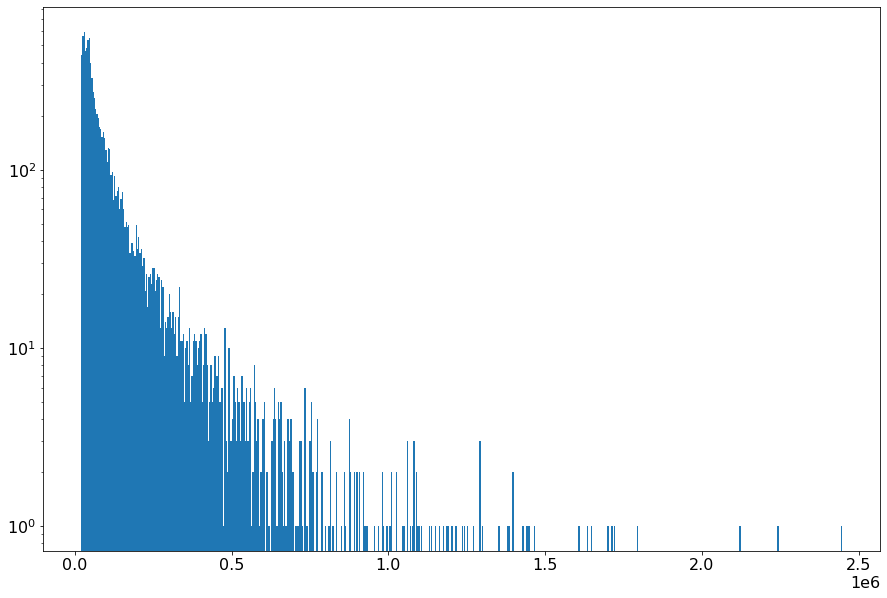

In [10]:
fig = plt.figure(figsize=(15, 10))
_ = plt.hist(energia, bins=600)
plt.yscale('log')

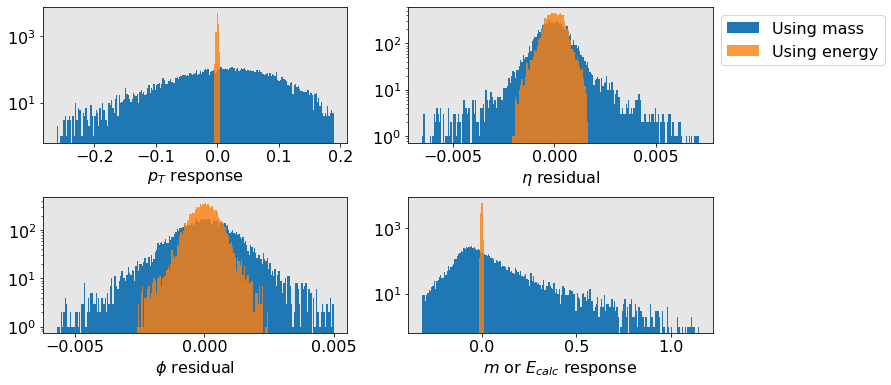

In [11]:
fig = plt.figure(figsize=(12, 6))
n_bins = 216
edges = {}
for f, input_type in enumerate(['mass', 'energy']):
    for i, branch in enumerate(res[input_type].keys()):
        plt.subplot(2, 2, i+1)
        plt.gca().set_facecolor((0.9, 0.9, 0.9))
        
        
        percentiles = np.percentile(res[input_type][branch], (.5, 99.5))
        mask = (res[input_type][branch] > percentiles[0]) & (res[input_type][branch] < percentiles[1])
        
        limits = min(res[input_type][branch][mask]), max(res[input_type][branch][mask])
        bins = np.linspace(limits[0], limits[1], n_bins)
        
        if f == 0:
            _, bin_edges, _ = plt.hist(res[input_type][branch][mask], bins=bins, density=False, alpha=1-.2*f)
            edges[i] = bin_edges
        else:
            _ = plt.hist(res[input_type][branch][mask], bins=edges[i], density=False, alpha=1-.2*f)
        
        #_ = plt.hist(pred[branch], bins=bins, density=False, color=colors[1], alpha=0.7)
        
        if i < 3:
            plt.xlabel(labels[i] + ' ' + res_type[branches[i]])
        else:
            plt.xlabel('$m$ or ' + labels[i] + ' ' + res_type[branches[i]])
        plt.yscale('log')
        #if f == 0:
        #    ylims.append(plt.ylim())
        #else:
        #    plt.ylim(ylims[i])
        #if branch in branches[::3]:
        #    plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

plt.subplot(2, 2, 2)
plt.legend(['Using mass', 'Using energy'], bbox_to_anchor=(1, 1))
plt.subplots_adjust(hspace=0.4)

plt.subplot(2, 2, 3)
plt.xticks([-0.005, 0, 0.005]);

Text(0.5, 0, '$m$ [MeV]')

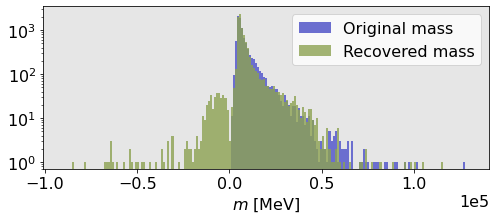

In [14]:
v = vector.obj(pt=preds['energy']['pt'], eta=preds['energy']['eta'], phi=preds['energy']['phi'], E=preds['energy']['Calculated_E'])
n_bins = 200
fig = plt.figure(figsize=(8, 3))
#bins = np.linspace(min(min(v.tau), min(origs['mass']['m'])), max(max(v.tau), max(origs['mass']['m'])), n_bins)
bins = np.linspace(-.9e5, 1.3e5, n_bins)
_ = plt.hist(origs['mass']['m'], bins=bins, color=colors[0])
_ = plt.hist(v.tau, bins=bins, alpha=0.8, color=colors[1])
plt.yscale('log')
ax = plt.gca()
ax.set_facecolor((0.9, 0.9, 0.9))
plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
plt.legend(['Original mass', 'Recovered mass'], bbox_to_anchor=(1,1))
plt.xlabel('$m$ [MeV]')

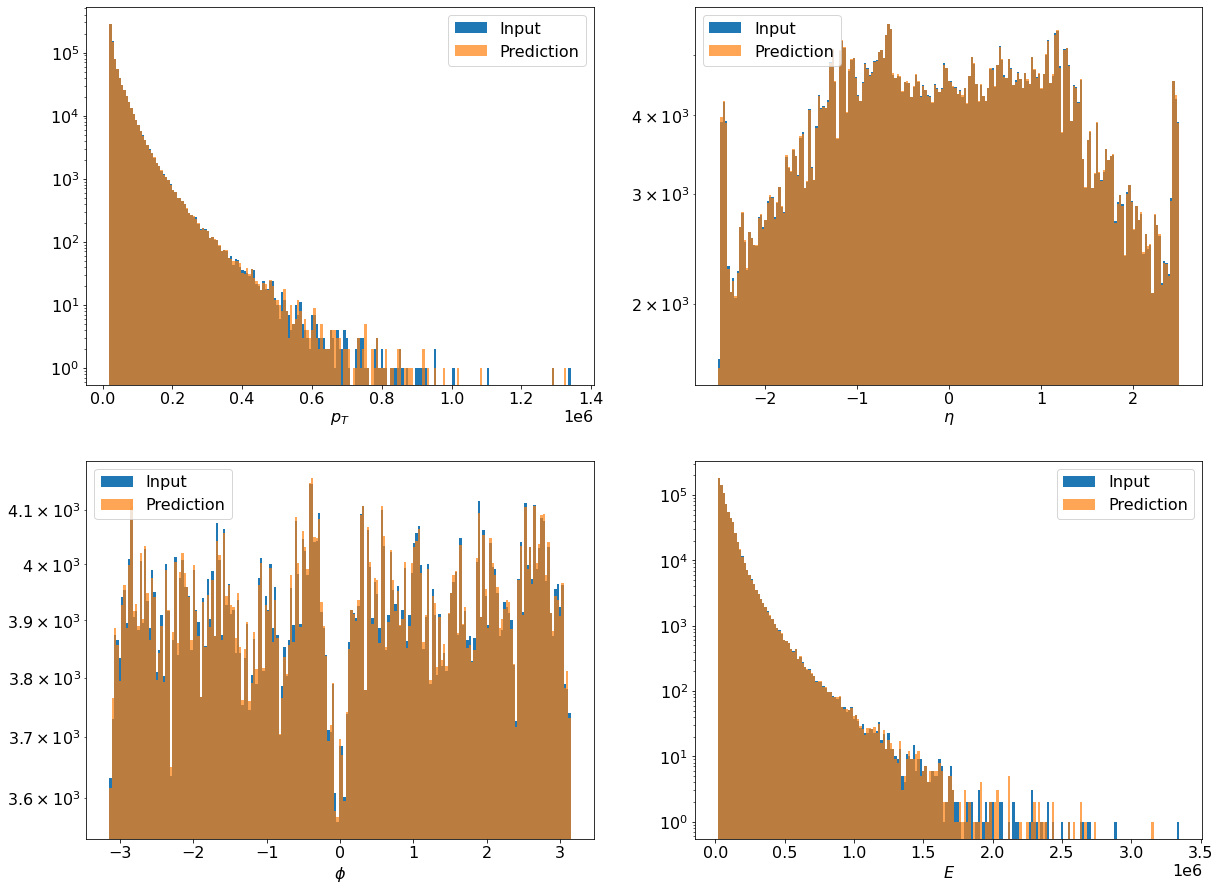

In [15]:
n_bins = 200
labels = ['$p_T$', '$\eta$', '$\phi$']
if 'Calculated_E' in branches:
    fourth_label = '$E_{calc}$'
elif 'm' in branches:
    fourth_label = '$m$'
else:
    fourth_label = '$E$'
labels.append(fourth_label)
fig = plt.figure(figsize=(20, 8*len(branches)))
for i, branch in enumerate(branches):
    plt.subplot(len(branches), 2, i+1)
    limits = (min(min(orig[branch]), min(pred[branch])), max(max(orig[branch]), max(pred[branch])))
    bins = np.linspace(limits[0], limits[1], n_bins)
    _ = plt.hist(orig[branch], bins=bins, density=False)
    _ = plt.hist(pred[branch], bins=bins, density=False, alpha=0.7)
    plt.legend(['Input', 'Output'])
    plt.xlabel(labels[i])
    plt.yscale('log')

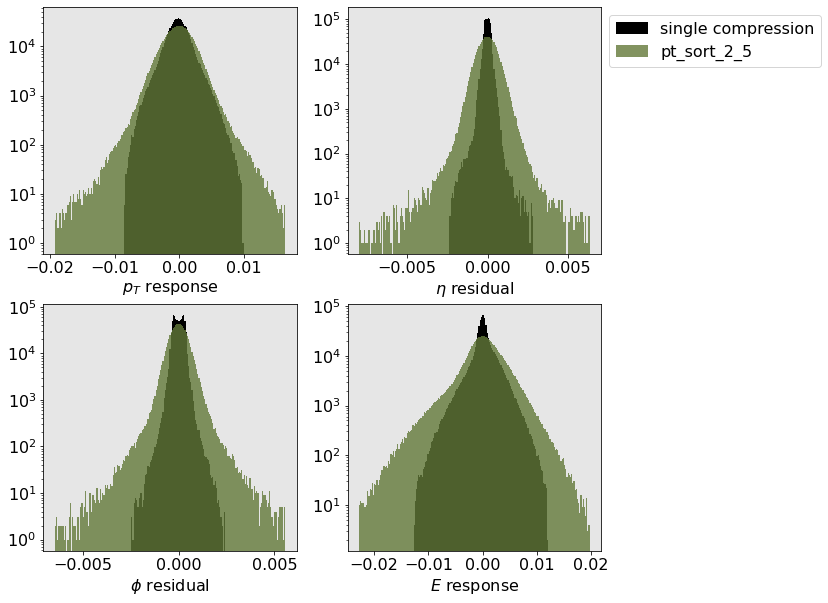

In [15]:
# Calculate responses and residuals

#model_names = ['run_20211026113204_d2lep_dim_4_same_event_1_3', # reference model
#               'run_20211028201105_d2lep_dim_4_same_event_3_8'] # best-performing same_event intermediate

model_names = ['run_20211026113204_d2lep_dim_4_same_event_1_3', # reference model
               'run_20211101114815_d2lep_dim_4_pt_sort_2_5']    # best-performing pt_sort intermediate

res_type['E'] = 'response'

n_bins = 200

#ranges = [(min(res[branch]), max(res[branch])) for branch in branches]
#limits = [np.linspace(a, b, n_bins) for (a, b) in ranges]
#limits = [np.linspace(a, b, n_bins) for (a, b) in [(-0.05, 0.05), (-0.05, 0.05), (-0.04, 0.04), (-0.02, 0.02), (-0.03, 0.03), (-0.03, 0.03)]]

bin_edges = {}
bin_counts = {}
bin_max_ixs = {}
masks = {}

percentiles = {}
percentile_values = [0.01, 99.99]

branch_symbols = dict(zip(branches, ['$p_T$', '$\eta$', '$\phi$', '$E$']))

colors = ['k', plt.get_cmap('tab20b').colors[4]]

fig = plt.figure(figsize=(10, 10))

maxs = {}
mins = {}

for branch in branches:
    
    maxs[branch] = -np.inf
    mins[branch] = np.inf
    
    for m, model_name in enumerate(model_names):
        orig = origs[model_name]
        pred = preds[model_name]
        res = pred - orig
        for column in res.columns:
            if res_type[column] == 'response':
                res[column] = res[column] / orig[column]
        
        percentiles[branch] = np.percentile(res[branch], percentile_values)
        masks[branch] = (res[branch] < percentiles[branch][1]) & (res[branch] > percentiles[branch][0])
        mask = masks[branch]

        maxs[branch] = max(maxs[branch], res[branch][mask].max())
        mins[branch] = min(mins[branch], res[branch][mask].min())

for m, model_name in enumerate(model_names):
    orig = origs[model_name]
    pred = preds[model_name]
    res = pred - orig
    for column in res.columns:
        if res_type[column] == 'response':
            res[column] = res[column] / orig[column]
    
    for i, branch in enumerate(branches):
        percentiles[branch] = np.percentile(res[branch], percentile_values)
        masks[branch] = (res[branch] < percentiles[branch][1]) & (res[branch] > percentiles[branch][0])
        mask = masks[branch]

        # Res plot
        #bins = np.linspace(percentiles[branch][0], percentiles[branch][1], n_bins)
        bins = np.linspace(mins[branch], maxs[branch], n_bins)
        plt.subplot(2, 2, i+1)
        plt.gca().set_facecolor((0.9, 0.9, 0.9))
        
        bin_counts[branch], bin_edges[branch], _ = plt.hist(res[branch][mask], bins=bins, density=False, alpha=1-.2*m, color=colors[m])
        
        bin_max_ixs[branch] = np.where(bin_counts[branch] == bin_counts[branch].max())  
        plt.xlabel(branch_symbols[branch] + ' ' + res_type[branch])
        
        #plt.gca().ticklabel_format(axis="y", style='sci', scilimits=(0,0))
        plt.yscale('log')

        # # Box plot
        # plt.subplot(len(branches), 3, 3*i+2)
        # box = plt.boxplot(res[branch], sym='.', labels=[branch + ' ' + res_type[branch] + ' quartiles'])
        # plt.grid()

        # # Original distribution
        # plt.subplot(len(branches), 3, 3*i+3)
        # counts, edges, _ = plt.hist(orig[branch], bins=n_bins, label='All jets')
        # plt.hist(orig[branch][~mask], bins=edges, label='Reconstruction outliers (worst 1%)', color='tab:olive')
        # plt.xlabel(branch + ' input values')
        # plt.legend()
        # plt.yscale('log')
    
plt.subplot(2, 2, 2)
plt.legend(['single compression', 'pt_sort_2_5'], bbox_to_anchor=(1,1))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

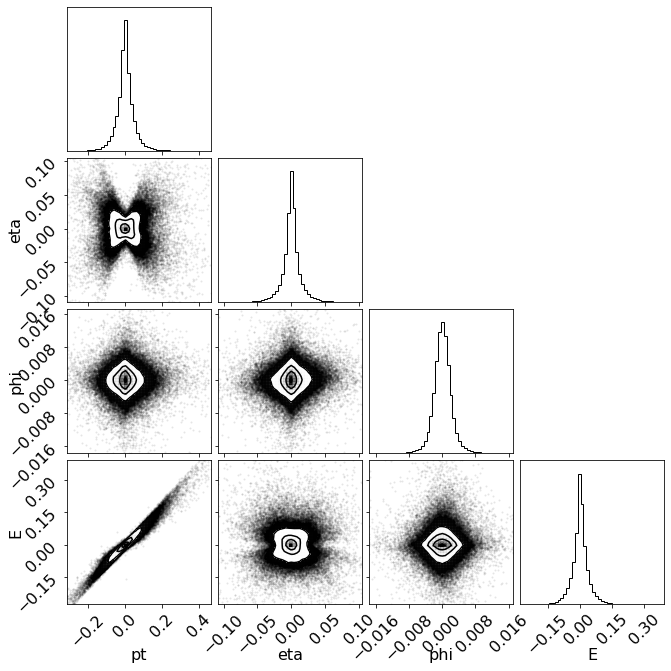

In [97]:
_ = corner.corner(res, range=[0.999 for _ in range(4)], bins=50)

In [19]:
total_masking = np.array([True] * len(res))
print('Total number of jets:', sum(total_masking))
for branch in branches:
    total_masking = total_masking & masks[branch]
    print('Mask progression...', sum(total_masking))
print('Total number of jets:', len(res))
print('Number of jets with NO values in 1% extreme range:', sum(total_masking))

Total number of jets: 779654
Mask progression... 778094
Mask progression... 776709
Mask progression... 775501
Mask progression... 774182
Total number of jets: 779654
Number of jets with NO values in 1% extreme range: 774182


In [62]:
info = pd.read_pickle(r'F:\Master\Data\storage\model-info\run_20211025122900_dim_4_same_event_1_3.info')
print(info)

({'n_features': 4, 'group_size': 1, 'latent_space_size': 3, 'mode': 'same_event', 'intermediate': False, 'name': 'same_event_1_3', 'n_epochs': 1, 'model_type': 'single'}, 'run_20211025122900_dim_4_same_event_1_3', '4-200-100-50-3-50-100-200-4, activation function: Tanh()')
